# Cryptography

**Why cryptography?**
- Cryptographic analysis provides distinct advantages over some more en vogue comp neuro methods, like deep learning
  - It sits at a crucial point between supervised and unsupervised learning: you don't need training labels, but you also pull on pre-existing knowledge about the structure of information in the world
- Cryptographic analysis centers on using the underlying non-uniform distribution of data in the world to decode information
  - This is something humans naturally do to learn -- e.g. children use morpheme co-ocurance-rates to learn language
  - On a similar note, human adults are able to remember larger numbers of social relationships when they exhibit properties that make them representable in a lower number of bits 

**What will we cover in this notebook?**
- A hands-on example of using cryptographic analysis to break a substitution cipher in English

In [ ]:
#file imports
import nltk
from nltk.corpus import words as wordlist
import re
import pandas
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from IPython.display import HTML, display
import string

#set random seed and download corpora
os.environ['PYTHONHASHSEED'] = '0'
nltk.download('words')
nltk.download('gutenberg')

#make sure the display fits the width of the page
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

def get_letter_distribution(text, plot=False, title='', zipfian=False):
  text = re.sub(r'[^a-z]', '', text.lower())
  letter_counts = Counter(sorted(text))
  if plot:
    if zipfian:
      letters, vals = zip(*letter_counts.most_common())
      letters = np.array(letters)
      vals = np.array(vals).astype('float64')
      vals /= sum(vals)
      plt.bar(letters, vals)
    else:
      plt.bar(letter_counts.keys(), np.array(list(letter_counts.values()))/len(text))
    plt.ylim([0,0.2])
    plt.xlabel('letter')
    plt.ylabel('percentage of all letters')
    plt.title(title)
    plt.show()
  return letter_counts

alphabet = list(string.ascii_lowercase)
random.shuffle(alphabet)
cipher = dict(zip(sorted(alphabet), alphabet))
for letter in alphabet:
  cipher[letter.upper()] = cipher[letter].upper()

original_quote = nltk.corpus.gutenberg.raw(nltk.corpus.gutenberg.fileids()[1])
encrypted_quote = ''
for letter in original_quote:
  if letter in cipher.keys():
    encrypted_quote+=(cipher[letter])
  else:
    encrypted_quote+=(letter)

def decrypt(encrypted_quote, reverse_cipher):
  unencrypted_quote = ''
  for letter in encrypted_quote:
    if letter in reverse_cipher.keys():
      unencrypted_quote+=(reverse_cipher[letter])
    else:
      unencrypted_quote+=(letter)
  return unencrypted_quote

def fix_single_letter_words(encrypted_quote, reverse_cipher):
  single_letter_words = []
  for word in re.sub(r'[^a-zA-Z ]', '', encrypted_quote.lower()).split():
    if len(word) == 1:
      single_letter_words.append(word)
  (first, count1), (second, count2) = Counter(single_letter_words).most_common()[0:2]  
  if reverse_cipher[first] != 'a':
    for letter in reverse_cipher.keys():
      if reverse_cipher[letter] == 'a':
        reverse_cipher[letter] = reverse_cipher[first]
      if reverse_cipher[letter] == 'A':
        reverse_cipher[letter] = reverse_cipher[first].upper()
    reverse_cipher[first] = 'a'
    reverse_cipher[first.upper()] = 'A'
  if reverse_cipher[second] != 'i':
    for letter in reverse_cipher.keys():
      if reverse_cipher[letter] == 'i':
        reverse_cipher[letter] = reverse_cipher[second]
      if reverse_cipher[letter] == 'I':
        reverse_cipher[letter] = reverse_cipher[second].upper()
    reverse_cipher[second] = 'i'
    reverse_cipher[second.upper()] = 'I'
  return reverse_cipher

english = set(wordlist.words())
def get_percent_real(recovered):
  english = set(wordlist.words())
  reals = [word in english for word in re.sub(r'[^a-zA-Z ]', '', recovered.lower()).split()]
  percent_real = sum(reals)/len(reals)
  return percent_real

import copy
def swap_keys(reverse_cipher, L1, L2): 
  updated = copy.deepcopy(reverse_cipher)
  L1V, L2V = reverse_cipher[L1], reverse_cipher[L2]
  updated[L1], updated[L2] = L2V, L1V
  updated[L1.upper()], updated[L2.upper()] = L2V.upper(), L1V.upper()
  return updated

def swap_keys_inplace(reverse_cipher, L1, L2): 
  L1V, L2V = reverse_cipher[L1], reverse_cipher[L2]
  reverse_cipher[L1], reverse_cipher[L2] = L2V, L1V
  reverse_cipher[L1.upper()], reverse_cipher[L2.upper()] = L2V.upper(), L1V.upper()


def improve_deciphering(second_pass, reverse_cipher, percent_real_before):
  english = set(wordlist.words())
  c = get_letter_distribution(second_pass)
  dists = np.ones((26,26))
  for i in range(26):
    for j in range(i+1,26):
      dists[i,j] = abs(c[alphabet[i]] - c[alphabet[j]])/sum(c.values())
  percent_real = percent_real_before
  indeces = np.argsort(dists.flatten())
  while percent_real < 0.81:
    for idx in indeces:
      i,j=np.unravel_index(idx, (26,26))
      L1, L2 = alphabet[i], alphabet[j]
      updated = swap_keys(reverse_cipher, L1, L2)
      unencrypted_quote = ''
      for letter in encrypted_quote:
        if letter in updated.keys():
          unencrypted_quote+=(updated[letter])
        else:
          unencrypted_quote+=(letter)
      reals = [word in english for word in re.sub(r'[^a-zA-Z ]', '', unencrypted_quote.lower()).split()]
      percent_real = sum(reals)/len(reals)
      print(percent_real)
      if percent_real > percent_real_before+(0.82-percent_real_before)/4:
        print(percent_real, '\t', L1, '\t',L2,'\n\n')
        print(re.sub(r'[^a-zA-Z ]', '', unencrypted_quote.lower())[35:776])
        swap_keys_inplace(reverse_cipher, L1, L2)
        percent_real_before = percent_real
        break
    return reverse_cipher

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


Let's use some cryptanalysis to solve a letter subtitution cipher. The text below is a passage from a classic novel in which each letter has been replaced with another letter from the English alphabet, with unique pairings. 

In [ ]:
print(encrypted_quote[35:776])

Skxdbjf 1


Rcf Yxabjf Jaacpb, pq Tjaangsk Kxaa, cg Rpijfrjbrkcfj, yxr x ixg ykp,
qpf kcr pyg xihrjijgb, gjzjf bppt hd xgn oppt ohb bkj Oxfpgjbxmj;
bkjfj kj qphge psshdxbcpg qpf xg ceaj kphf, xge spgrpaxbcpg cg x
ecrbfjrrje pgj; bkjfj kcr qxshabcjr yjfj fphrje cgbp xeicfxbcpg xge
fjrdjsb, on spgbjidaxbcgm bkj acicbje fjigxgb pq bkj jxfacjrb dxbjgbr;
bkjfj xgn hgyjaspij rjgrxbcpgr, xfcrcgm qfpi epijrbcs xqqxcfr
skxgmje gxbhfxaan cgbp dcbn xge spgbjidb xr kj bhfgje pzjf
bkj xaiprb jgeajrr sfjxbcpgr pq bkj axrb sjgbhfn; xge bkjfj,
cq jzjfn pbkjf ajxq yjfj dpyjfajrr, kj sphae fjxe kcr pyg kcrbpfn
ycbk xg cgbjfjrb ykcsk gjzjf qxcaje.  Bkcr yxr bkj dxmj xb ykcsk
bkj qxzphfcbj zpahij xayxnr pdjgje:

           "JAACPB PQ TJAANGSK KXAA.

"


If we wanted to decrypt this, we could try a few approaches. We could brute force it, trying every single possible combination of unique letter replacement pairs. This comes out to $26! = 4.03e^{26}$ potential combinations, which would take a prohibitively long time to run.
<br><br>
A more fruitful aproach might be to use the underlying statistics of the English language to help us seed this process with educated guesses. Let's take a look at how often particular letters show up in English text (as approximated by a collection of classic novels from Project Gutenberg). 

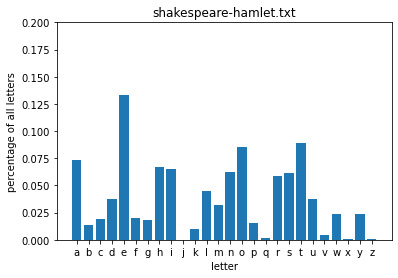

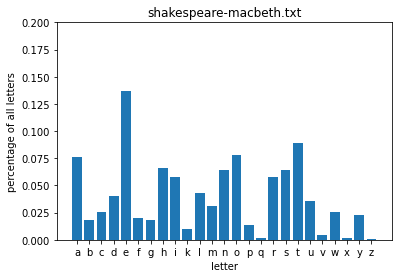

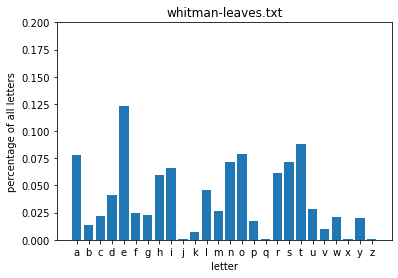

In [ ]:
for fileid in nltk.corpus.gutenberg.fileids()[-3:]:
  words = re.sub(r'[^a-z]', '', nltk.corpus.gutenberg.raw(fileid).lower())
  get_letter_distribution(words, plot=True, title=fileid)

From the above distributions, you can see that some letters are used consistently more frequently than others across these texts. Let's take a look at the distribution defined be the average of all of these texts:

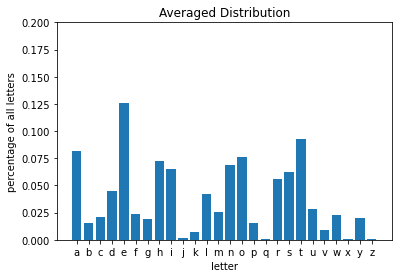

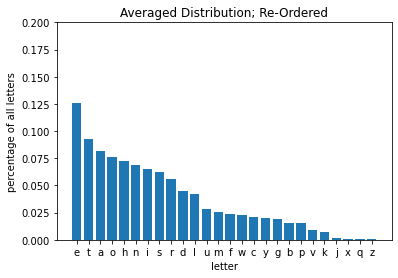

In [ ]:
words = ''
for fileid in nltk.corpus.gutenberg.fileids():
  words += re.sub(r'[^a-z]', '', nltk.corpus.gutenberg.raw(fileid).lower())
get_letter_distribution(words, plot=True, title='Averaged Distribution');
get_letter_distribution(words, plot=True, title='Averaged Distribution; Re-Ordered', zipfian=True);

With this knowledge about expected patterns of letter occurances, let's see how they compare to the statistics of our encrypted text.

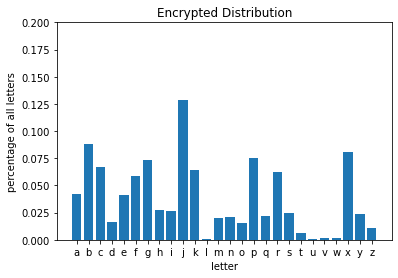

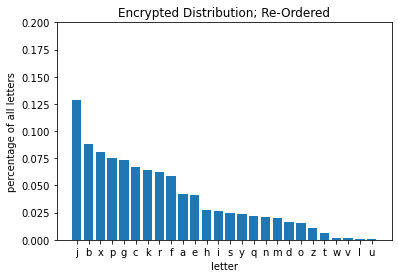

In [ ]:
get_letter_distribution(encrypted_quote, plot=True, title='Encrypted Distribution');
get_letter_distribution(encrypted_quote, plot=True, title='Encrypted Distribution; Re-Ordered', zipfian=True);

As the above distribution shows us, even though each individual letter in the encrypted text no longer has the same occurance probability as it does in typical English text, the general shape of the re-ordered distribution is still the same. We can use this to build a first-pass remapping to attempt deciphering the encrypted text, substituting each encrypted letter with the English letter closest in usage frequency.


In [ ]:
quote_dist = list(map(lambda x: x[0], Counter(re.sub(r'[^a-z]', '', encrypted_quote.lower())).most_common()))
english_dist = list(map(lambda x: x[0], Counter(re.sub(r'[^a-z]', '', words.lower())).most_common()))
reverse_cipher = dict(zip(quote_dist, english_dist))
for letter in alphabet:
  reverse_cipher[letter.upper()] = reverse_cipher[letter].upper()

In [ ]:
first_pass = decrypt(encrypted_quote, reverse_cipher)
print(first_pass[35:776])

Fiabter 1


Snr Wadter Eddnot, oc Keddyhfi Iadd, nh Somersetsinre, was a mah wio,
cor ins owh amusemeht, hever took ub ahy pook put tie Parohetage;
tiere ie couhl offubatnoh cor ah nlde iour, ahl fohsodatnoh nh a
lnstressel ohe; tiere ins cafudtnes were rousel nhto almnratnoh ahl
resbeft, py fohtembdatnhg tie dnmntel remhaht oc tie eardnest batehts;
tiere ahy uhwedfome sehsatnohs, arnsnhg crom lomestnf accanrs
fiahgel haturaddy nhto bnty ahl fohtembt as ie turhel over
tie admost ehldess freatnohs oc tie dast fehtury; ahl tiere,
nc every otier deac were bowerdess, ie foudl real ins owh instory
wnti ah nhterest winfi hever candel.  Tins was tie bage at winfi
tie cavournte vodume adways obehel:

           "EDDNOT OC KEDDYHFI IADD.

"


While our first pass definitely gets us closer to the original text, it's not quite good enough (unless you, like yours truly, happen to be both a Jane Austen fan and one accustomed to reading through heavy mispellings). 
<br><br>
At this point, we'll want to use some basic facts about English to help us out. For example, we want to make sure that any single-letter words are either assigned to A or I. 

In [ ]:
reverse_cipher = fix_single_letter_words(encrypted_quote, reverse_cipher)
second_pass = decrypt(encrypted_quote, reverse_cipher)
print(second_pass[35:776])

Fnabter 1


Sir Wadter Eddiot, oc Keddyhfn Nadd, ih Somersetsnire, was a mah wno,
cor nis owh amusemeht, hever took ub ahy pook put tne Parohetage;
tnere ne couhl offubatioh cor ah ilde nour, ahl fohsodatioh ih a
listressel ohe; tnere nis cafudties were rousel ihto almiratioh ahl
resbeft, py fohtembdatihg tne dimitel remhaht oc tne eardiest batehts;
tnere ahy uhwedfome sehsatiohs, arisihg crom lomestif accairs
fnahgel haturaddy ihto bity ahl fohtembt as ne turhel over
tne admost ehldess freatiohs oc tne dast fehtury; ahl tnere,
ic every otner deac were bowerdess, ne foudl real nis owh nistory
witn ah ihterest wnifn hever caidel.  Tnis was tne bage at wnifn
tne cavourite vodume adways obehel:

           "EDDIOT OC KEDDYHFN NADD.

"


Intuitively, this text feels closer to English text than the previous two. But at this point, we might decide that we want a better metric to determine closeness to the original text than our gut feeling of what looks better.
<br><br>
As we go through the decrypted text (which is significantly larger than the single-paragraph sample displayed above), we can use a cannonical list of English words, then check what percentage of the words in our recovered text are true English words.  

In [ ]:
percent_real_before = get_percent_real(second_pass)
print(percent_real_before,'% of recovered words were valid English')

0.29535548269005385 % of recovered words were valid English


We can definitely do better than 30% -- in fact, the original text contains 81.7% accepted English words. In order to improve our decryption, we'll try swapping out letter mappings for letters that have the most similar probabilities in English (i.e. R and S both constitute approximately 7.2% of letters used in this corpus). If the percentage of accepted English words improves by making a substitution, we keep it. Let's watch this technique at work. *N.B. This make take a few minutes; feel free to make a nice cup of tea while the next cell runs!*

In [1]:
c = get_letter_distribution(second_pass)
dists = np.ones((26,26))
for i in range(26):
  for j in range(i+1,26):
    dists[i,j] = abs(c[alphabet[i]] - c[alphabet[j]])/sum(c.values())
percent_real = percent_real_before
indeces = np.argsort(dists.flatten())
while percent_real < 0.81:
  for idx in indeces:
    i,j = np.unravel_index(idx, (26,26))
    L1, L2 = alphabet[i], alphabet[j]
    updated = swap_keys(reverse_cipher, L1, L2)
    unencrypted_quote = ''
    for letter in encrypted_quote:
      if letter in updated.keys():
        unencrypted_quote += (updated[letter])
      else:
        unencrypted_quote += (letter)
    reals = [word in english for word in re.sub(r'[^a-zA-Z ]', '', unencrypted_quote.lower()).split()]
    percent_real = sum(reals)/len(reals)
    if percent_real > percent_real_before+(0.82-percent_real_before)/4:
      print('swap', L1.upper(), 'and',L2.upper(),'\tpercent valid English words:', percent_real,'\n\n')
      # print(re.sub(r'[^a-zA-Z ]', '', unencrypted_quote.lower())[35:776])
      print(unencrypted_quote[35:776])
      swap_keys_inplace(reverse_cipher, L1, L2)
      percent_real_before = percent_real
      break

NameError: name 'get_letter_distribution' is not defined

And here we find outselves with the fully recovered opening paragraph of Jane Austen's timeless classic *Persuasion*, decrypted in a computationally feasible timeframe, based solely on our pre-existing knowledge of how frequently different letters are used in the English language.
<br><br>
Now that you (hopefully!) have a stronger intuition for frequency-based decryption techniques, my recommended reading is [A cryptography-based approach for movement decoding](https://www.nature.com/articles/s41551-017-0169-7) from Eva Dyer and her colleagues in Konrad Kording's lab, who used this frequency-based approach to decode motor activity from macaque neural recordings. 